In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn as nn
from torchvision.models import resnet50


In [2]:
_, _, files = next(os.walk("dataset/Shale"))
len(files)


400

In [3]:
data_dir = "./dataset"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [4]:
full_dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform)

dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
def train_epoch(model, train_loader, optimizer, criterion):
    train_loss = 0.0
    train_acc = []
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(x_batch)
        
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        _, preds = torch.max(y_pred, 1)
        train_acc.extend(preds.cpu().numpy() == y_batch.cpu().numpy())
        
    train_loss = train_loss / len(train_loader)
    accuracy = np.mean(train_acc)
    
    return train_loss, accuracy
        
        
    
def evaluation(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_acc = []
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred = model(x_batch)
        
        loss = criterion(y_pred, y_batch)
        
        val_loss += loss.item()
        
        _, preds = torch.max(y_pred, 1)
        val_acc.extend(preds.cpu().numpy() == y_batch.cpu().numpy())
        
    val_loss = val_loss / len(train_loader)
    accuracy = np.mean(val_acc)
    
    return val_loss, accuracy
    

In [6]:
def plot_training_history(history, val_every=5):
    # print(history)
    clear_output(wait=True)  # очищает предыдущий вывод
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    
    # Валидационные точки только там, где они есть
    val_epochs = [i for i in range(len(history['train_loss'])) if i % val_every == 0]
    if len(val_epochs) > len(history['val_loss']):
        val_epochs = val_epochs[:len(history['val_loss'])]
    
    if (len(history['val_loss']) > 0):
        ax1.plot(val_epochs, history['val_loss'], 'o-', label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    if (len(history['val_loss']) > 0):
        ax2.plot(val_epochs, history['val_acc'], 'o-', label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [7]:
def train_process(model, train_loader, val_loader, optimizer, criterion, num_epochs, val_every=5):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in tqdm(range(num_epochs)):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        
        if (epoch%val_every == 0):
            val_loss, val_acc = evaluation(model, val_loader, criterion)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        plot_training_history(history, val_every=val_every)
    return history
            

In [8]:
def train_batchwise(model, train_loader, val_loader, optimizer, criterion,
                    num_epochs, val_every_batches=1, val_fraction=1.0):
    """
    val_every_batches: каждые сколько батчей делать валидацию
    val_fraction: какую долю val_loader использовать для ускорения (0 < val_fraction <= 1)
    """
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    step = 0
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            step += 1
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(x_batch)
            
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            # train acc
            _, preds = torch.max(y_pred, 1)
            acc = (preds == y_batch).float().mean().item()
            
            # логируем
            history['train_loss'].append(loss.item())
            history['train_acc'].append(acc)
            
            # валидация каждые val_every_batches
            if step % val_every_batches == 0:
                val_loss, val_acc = evaluation(model, val_loader, criterion, val_fraction)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
            
            # обновляем график
            plot_training_history(history)
    
    return history


def evaluation(model, val_loader, criterion, fraction=1.0):
    model.eval()
    val_loss = 0.0
    val_acc = []
    n_batches = int(len(val_loader) * fraction)
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(val_loader):
            if i >= n_batches:  # ограничиваемся fraction
                break
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
            
            _, preds = torch.max(y_pred, 1)
            val_acc.extend((preds == y_batch).cpu().numpy())
    
    val_loss /= n_batches
    accuracy = np.mean(val_acc)
    return val_loss, accuracy


def plot_training_history(history):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss
    ax1.plot(history['train_loss'], label='Train Loss', alpha=0.7)
    if len(history['val_loss']) > 0:
        ax1.plot(np.linspace(0, len(history['train_loss']), len(history['val_loss'])),
                 history['val_loss'], 'o-', label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy', alpha=0.7)
    if len(history['val_acc']) > 0:
        ax2.plot(np.linspace(0, len(history['train_acc']), len(history['val_acc'])),
                 history['val_acc'], 'o-', label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


In [9]:
# Define the model
model = resnet50(pretrained=True)

# Replace the last layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, (3))


/Users/kirillfrolov/Documents/IW_proj/geology/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kirillfrolov/Documents/IW_proj/geology/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-7)

device = torch.device('mps')
model = model.to(device)

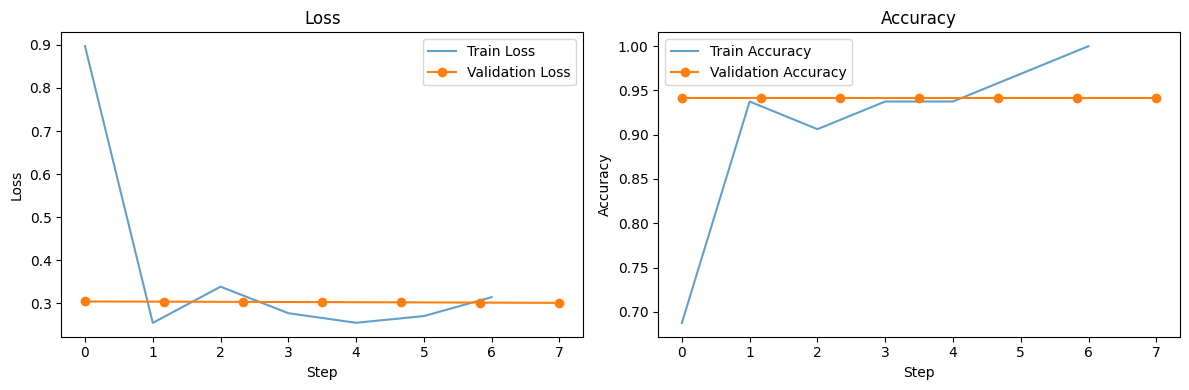

Epoch 1/5:  26%|██▌       | 7/27 [00:23<01:05,  3.30s/it]


KeyboardInterrupt: 

In [16]:
train_batchwise(model, train_loader, val_loader, optim, criterion, 5)

In [17]:
def test_model(model, test_loader, criterion, return_preds=False):
    """
    Оценка модели на тестовом датасете.
    
    return_preds: если True → вернёт ещё (y_true, y_pred)
    """
    model.eval()
    test_loss = 0.0
    test_acc = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
            
            _, preds = torch.max(y_pred, 1)
            test_acc.extend((preds == y_batch).cpu().numpy())
            
            if return_preds:
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
    
    test_loss /= len(test_loader)
    accuracy = np.mean(test_acc)
    
    if return_preds:
        return test_loss, accuracy, np.array(all_labels), np.array(all_preds)
    else:
        return test_loss, accuracy


In [18]:
# только loss и accuracy
test_loss, test_acc = test_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.2539, Test Accuracy: 0.9583


Загрузка случайных изображений...
Выполнение предсказаний...
Создание визуализации...


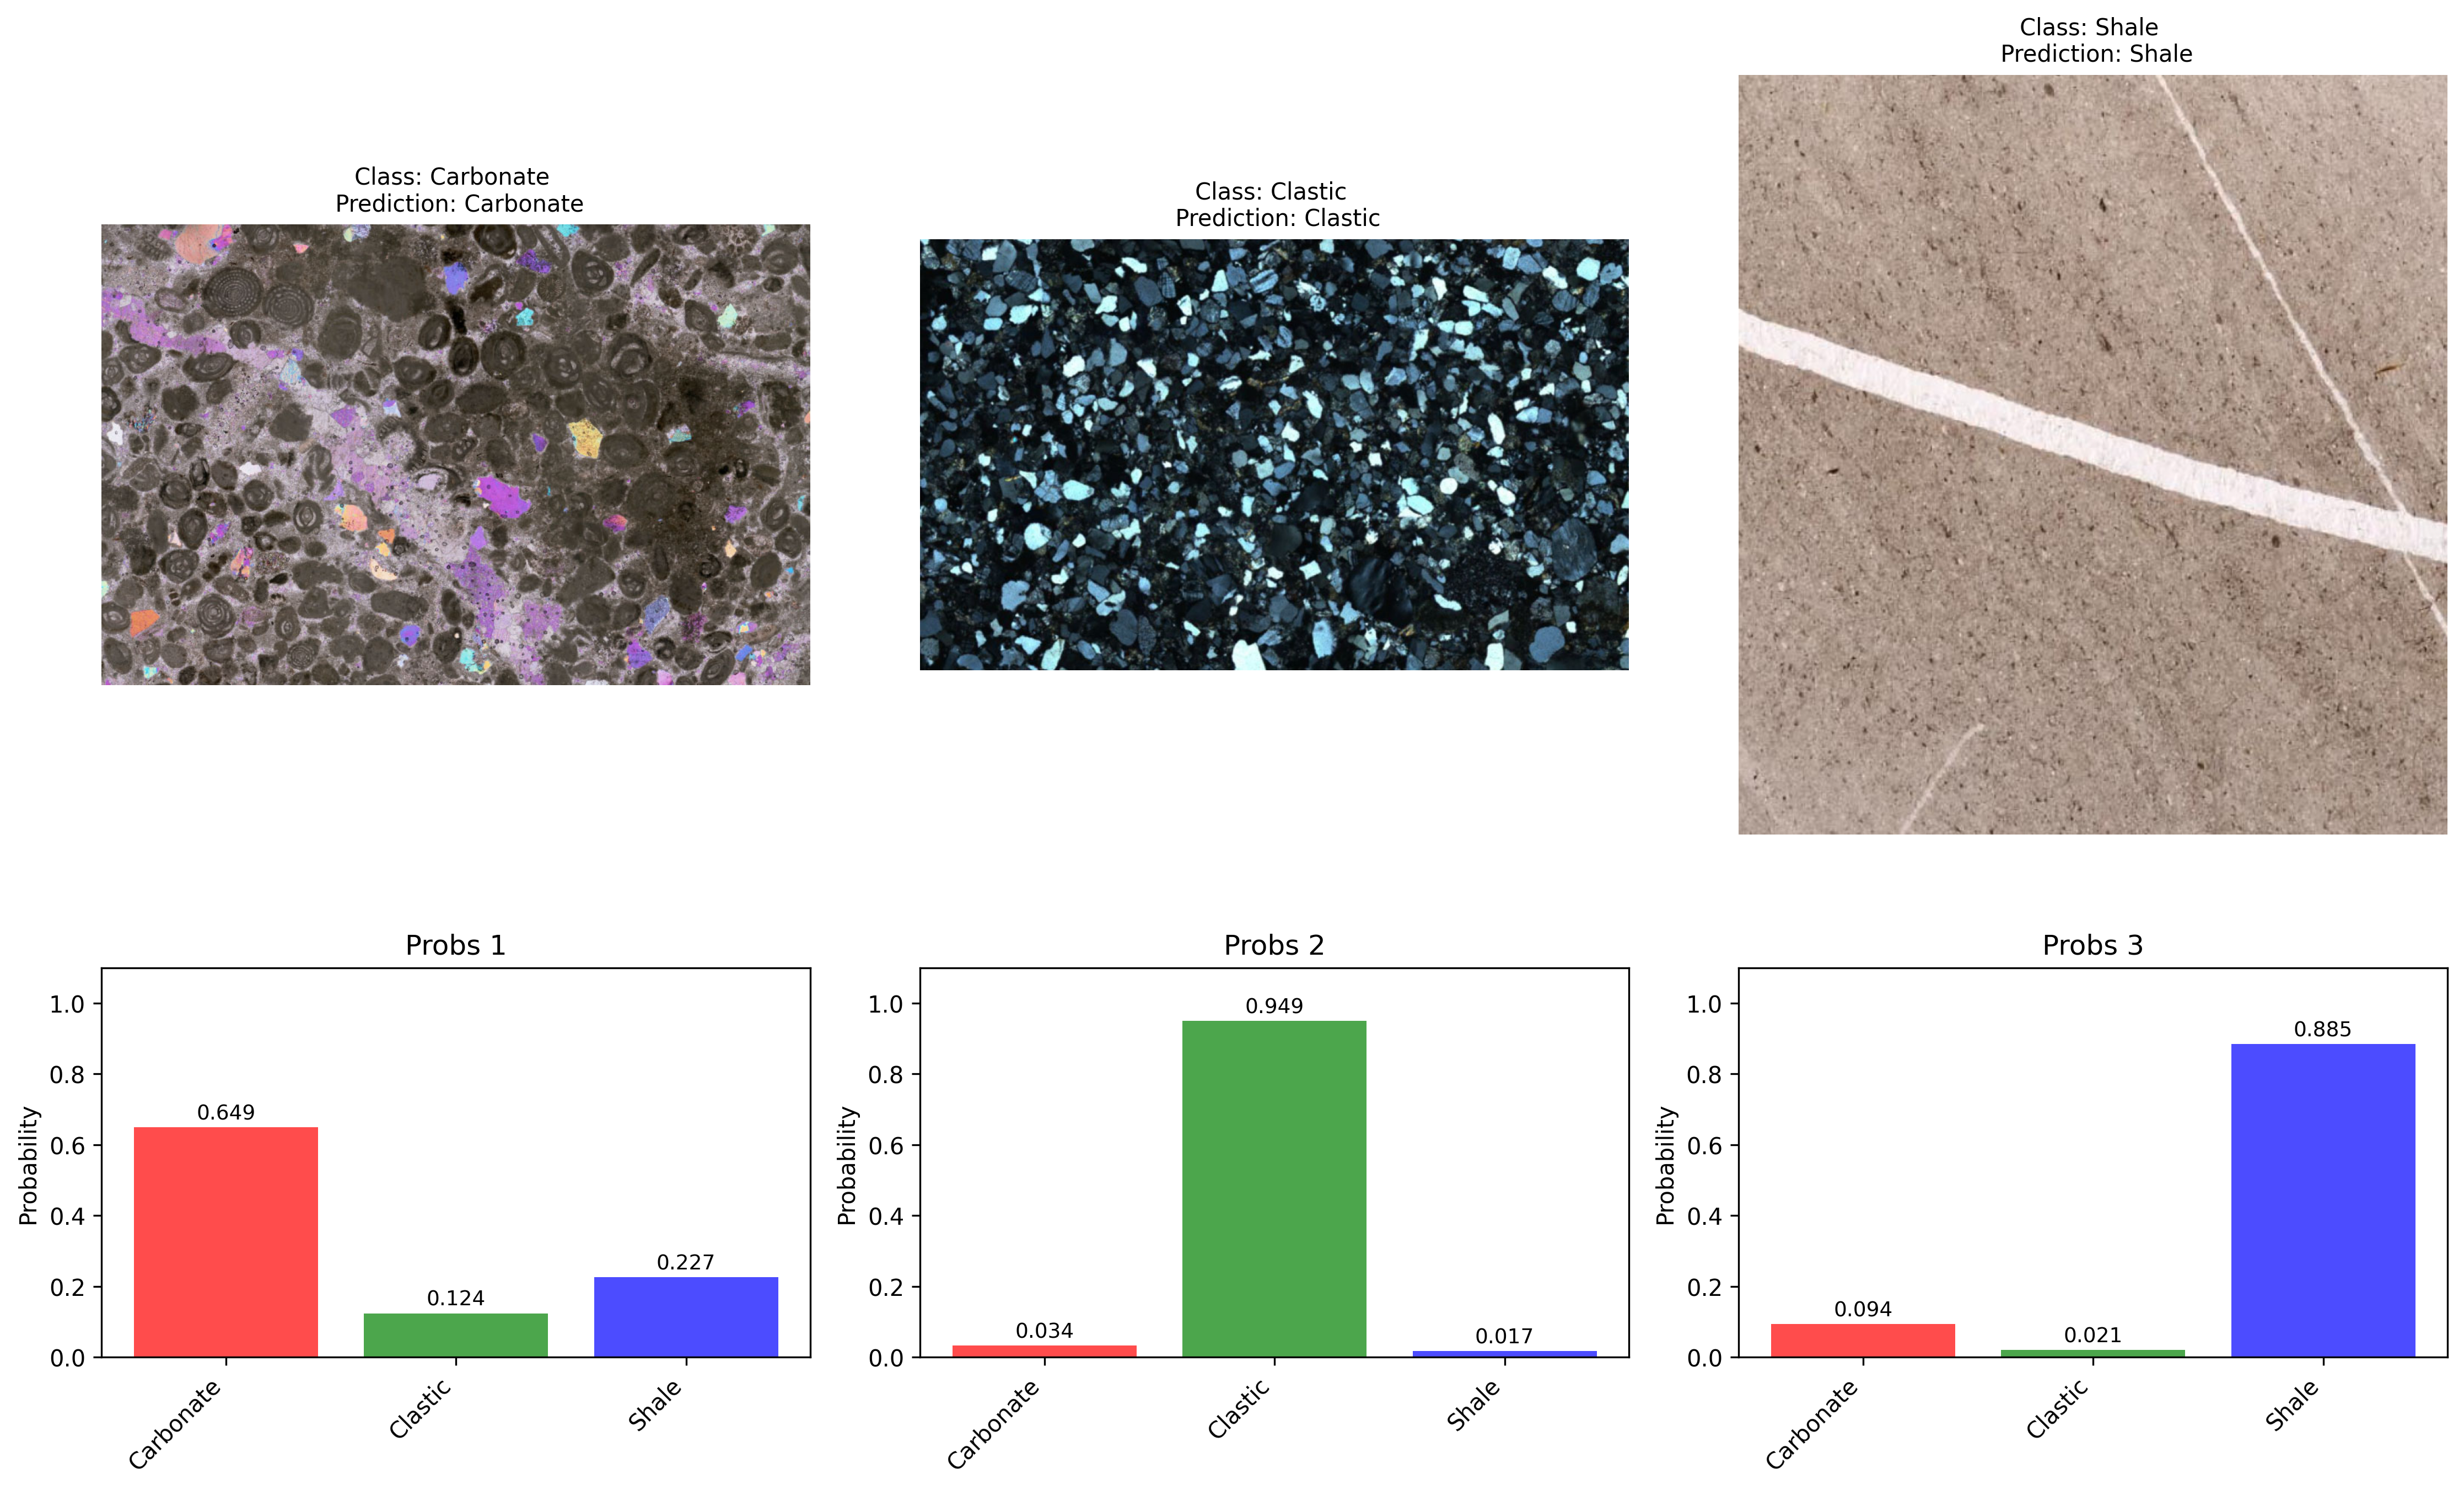


Результаты предсказаний:

Изображение 1: 113_04882.jpg
Истинный класс: Carbonate
Предсказанный класс: Carbonate
Probabilies:
  Carbonate: 0.6493
  Clastic: 0.1241
  Shale: 0.2266

Изображение 2: 112_04718.jpg
Истинный класс: Clastic
Предсказанный класс: Clastic
Probabilies:
  Carbonate: 0.0335
  Clastic: 0.9494
  Shale: 0.0171

Изображение 3: 114_05425.jpg
Истинный класс: Shale
Предсказанный класс: Shale
Probabilies:
  Carbonate: 0.0939
  Clastic: 0.0212
  Shale: 0.8849


In [27]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms

def load_random_images_from_folders(base_path, class_folders):
    """
    Загружает по одному случайному изображению из каждой папки класса
    """
    images = []
    image_paths = []
    
    for class_folder in class_folders:
        folder_path = os.path.join(base_path, class_folder)
        if os.path.exists(folder_path):
            # Получаем список всех изображений в папке
            image_files = [f for f in os.listdir(folder_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            
            if image_files:
                # Выбираем случайное изображение
                random_image = random.choice(image_files)
                image_path = os.path.join(folder_path, random_image)
                
                # Загружаем изображение
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                image_paths.append(image_path)
            else:
                print(f"В папке {class_folder} нет изображений")
                images.append(None)
                image_paths.append(None)
        else:
            print(f"Папка {class_folder} не существует")
            images.append(None)
            image_paths.append(None)
    
    return images, image_paths

def predict_images(model, images, transform, class_names, device='cpu'):
    """
    Делает предсказания для списка изображений
    """
    predictions = []
    probabilities = []
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for img in images:
            if img is not None:
                # Преобразуем изображение
                img_transformed = transform(Image.fromarray(img))
                img_transformed = img_transformed.unsqueeze(0).to(device)
                
                # Предсказание
                output = model(img_transformed)
                probs = torch.nn.functional.softmax(output, dim=1)
                pred_class = torch.argmax(probs, dim=1).item()
                
                predictions.append(pred_class)
                probabilities.append(probs.cpu().numpy()[0])
            else:
                predictions.append(None)
                probabilities.append(None)
    
    return predictions, probabilities

def create_visualization(images, predictions, probabilities, class_names, image_paths):
    """
    Создает визуализацию с изображениями и вероятностями
    """
    fig = plt.figure(figsize=(15, 10), dpi=300)
    
    # Создаем сетку 2x3 (3 изображения сверху, 3 графика снизу)
    gs = fig.add_gridspec(2, 3, height_ratios=[3, 1])
    
    # Отображаем изображения
    for i, (img, pred, prob, path) in enumerate(zip(images, predictions, probabilities, image_paths)):
        if img is not None:
            ax_img = fig.add_subplot(gs[0, i])
            ax_img.imshow(img)
            ax_img.set_title(f'Class: {class_names[i]} \n Prediction: {class_names[pred]}', 
                           fontsize=10)
            ax_img.axis('off')
    
    # Создаем bar plot для вероятностей
    colors = ['red', 'green', 'blue', 'orange', 'purple'][:len(class_names)]
    
    for i, prob in enumerate(probabilities):
        if prob is not None:
            ax_prob = fig.add_subplot(gs[1, i])
            bars = ax_prob.bar(range(len(class_names)), prob, color=colors, alpha=0.7)
            
            # Добавляем значения на столбцы
            for j, (bar, p) in enumerate(zip(bars, prob)):
                height = bar.get_height()
                ax_prob.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{p:.3f}', ha='center', va='bottom', fontsize=9)
            
            ax_prob.set_ylim(0, 1.1)
            ax_prob.set_xticks(range(len(class_names)))
            ax_prob.set_xticklabels(class_names, rotation=45, ha='right')
            ax_prob.set_ylabel('Probability')
            ax_prob.set_title(f'Probs {i+1}')
    
    plt.tight_layout()
    return fig

def main():
    # Конфигурация
    base_path = "dataset"  # Измените на ваш путь
    class_folders = ["Carbonate", "Clastic", "Shale"]  # Имена ваших папок с классами
    class_names = ["Carbonate", "Clastic", "Shale"]  # Имена классов для отображения
    
    # Загрузка модели (адаптируйте под вашу модель)
    # model_path = "путь/к/вашей/модели.pth"
    device = torch.device('mps')
    
    # Загрузка вашей модели
    # model = YourModelClass()
    # model.load_state_dict(torch.load(model_path))
    
    # Трансформации (адаптируйте под ваши преобразования)
    '''transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])'''
    
    # 1. Загрузка случайных изображений
    print("Загрузка случайных изображений...")
    images, image_paths = load_random_images_from_folders(base_path, class_folders)
    
    # 2. Предсказание
    print("Выполнение предсказаний...")
    predictions, probabilities = predict_images(model, images, transform, class_names, device)
    
    # 3. Создание визуализации
    print("Создание визуализации...")
    fig = create_visualization(images, predictions, probabilities, class_names, image_paths)
    
    # 4. Сохранение и отображение
    plt.savefig('predictions_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Вывод информации в консоль
    print("\nРезультаты предсказаний:")
    for i, (path, pred, prob) in enumerate(zip(image_paths, predictions, probabilities)):
        if path is not None:
            print(f"\nИзображение {i+1}: {os.path.basename(path)}")
            print(f"Истинный класс: {class_folders[i]}")
            print(f"Предсказанный класс: {class_names[pred]}")
            print("Probabilies:")
            for j, p in enumerate(prob):
                print(f"  {class_names[j]}: {p:.4f}")

if __name__ == "__main__":
    main()

In [28]:
torch.save(model.state_dict(), 'model.pth')